<a href="https://colab.research.google.com/github/jeean0668/GAN/blob/main/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git config --global users.name jeean0668
!git config --global users.email gijeeankyung@naver.com

In [11]:
!git clone https://github.com/jeean0668/GAN.git drive/MyDrive

fatal: destination path 'drive/MyDrive' already exists and is not an empty directory.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optims
from torch import nn
 
from PIL import Image
from torch.nn import Conv2d, Module
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch.autograd import grad, backward
 
import copy

In [ ]:
model = models.vgg19(pretrained=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize),
                             transforms.ToTensor()])
 
def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)
 
path = "drive/MyDrive/image/Matiz.jpeg"
path2 = "drive/MyDrive/image/Jiyoung.jpg"
 
style_img = image_loader(path) # 추가 필요
style_img = transforms.Resize([512, 512])(style_img)
content_img = image_loader(path2) # 추가 필요
content_img = transforms.Resize([512, 512])(content_img)

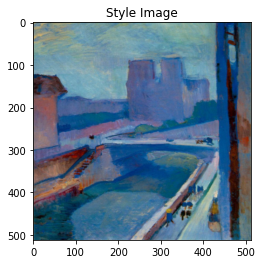

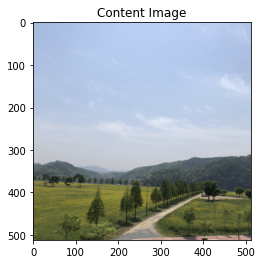

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
 
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
 
 
plt.figure()
imshow(style_img, title='Style Image')
 
plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
content_img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size()
 
  features = input.view(a*b, c*d)
  G = torch.mm(features, features.t()) 
  return G.div(a*b*c*d)

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
 
  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)
  def forward(self, img):
    return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
 
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, 
                               content_layers = content_layers_default,
                               style_layers = style_layers_default):
  cnn = copy.deepcopy(cnn) # model.vgg_19(pretrained = True).fetaures
 
  normalization = Normalization(normalization_mean, normalization_std).to(device)
 
  content_losses = []
  style_losses = []
 
  model = nn.Sequential(normalization)
 
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace = False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError("Unrecognized layer : {}".format(layer.__class__.__name__))
 
    model.add_module(name, layer)
 
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)
 
    if name in style_layers:
      target_features = model(style_img).detach()
      style_loss = StyleLoss(target_features) # the function calculating style loss
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[: (i+1)]
  return model, style_losses, content_losses

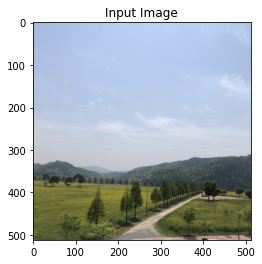

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)
 
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
  optimizer = optims.LBFGS([input_img.requires_grad_()])
  return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight = 1000000,content_weight=1):
  print("Building the style transfer model")
  model, style_losses, content_losses = get_style_model_and_losses(cnn,
      normalization_mean,normalization_std, style_img, content_img)
  
  optimizer = get_input_optimizer(input_img)
  print("Optimizing...")
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
 
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
 
      style_score *= style_weight
      content_score *= content_weight
 
      loss = style_score + content_score
      loss.backward()
 
      run[0] +=1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print("Style Loss : {:4f} Content Loss : {:4f}". format(style_score.item(),content_score.item()))
        print()
 
      return style_score + content_score
 
    optimizer.step(closure)
  input_img.data.clamp_(0,1)
  return input_img

Building the style transfer model
Optimizing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


run [50]:
Style Loss : 201.822815 Content Loss : 8.547605

run [100]:
Style Loss : 30.856539 Content Loss : 9.586890

run [150]:
Style Loss : 10.854157 Content Loss : 8.469452

run [200]:
Style Loss : 4.253920 Content Loss : 7.528672

run [250]:
Style Loss : 2.271571 Content Loss : 6.808704

run [300]:
Style Loss : 1.572481 Content Loss : 6.281886



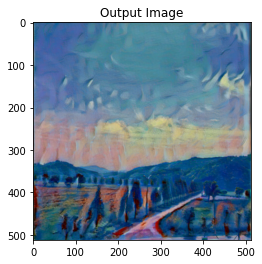

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
 
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
 
plt.figure()
imshow(output, title = "Output Image")
plt.ioff()
plt.show()

In [ ]:
from torchvision.utils import save_image
import os
 
def save(img, root, filename):
  save_image(img, os.path.join(root, "{}.png".format(filename)))
 
save(output, "drive/MyDrive/image", "jiyoung")

Using class, clean up the upward functions


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optims
from torch import nn

from PIL import Image
from torch.nn import Conv2d, Module
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch.autograd import grad, backward

import copy


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class StyleTransfer(nn.Module):
  def __init__(self, epochs = 300):
    super(StyleTransfer, self).__init__()
    self.feature_maps = models.vgg19(pretrained=True).features.to(device).eval()
    self.epochs = epochs
    self.alpha = 1000000
    self.betas = 1
    self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    self.std = torch.tensor([0.229, 0.224, 0.225]).to(device)

  def train(self, content_img, style_img, save_= True, debug_style = True, debug_content = True, debug_input = True):
    
    input_img = self.NoiseOrContent(content_img, content = True)
    input_img.data.clamp_(0,1)
    optimizer = self.get_optimizer(input_img)
    vgg_model = self.build_model(self.mean, self.std)

    if debug_style:
      style_img = self.imshow(style_img)
    if debug_content:
      content_img = self.imshow(content_img)
    if debug_input:
      input_img = self.imshow(input_img)

    for i in range(self.epochs):

      style_loss, content_loss = self.calculate_loss(vgg_model, content_img, style_img, input_img)
      style_score = sum(style_loss)
      content_score = sum(content_loss)
      total_loss = self.alpha * style_score + self.betas * content_score
      total_loss.backward()
      optimizer.step()
      if i % 50 == 0:
        print("run {} epochs".format(epoch))
        print("style loss : {}, content loss : {}".format(style_score.item(), content_score.item())) #일단 여기까지함
    
    input_img = self.imshow(input_img)
    if save_:
      self.save(input_img, filename, path)
    
  def imshow(self, img, is_transform = False, title = None):

    img_size = 512 if torch.cuda.is_available() else 128
    unloader = transforms.ToPILImage()

    if not is_transform:
      t = transforms.Compose([transforms.Resize(img_size)])
      result = t(img)
    
    result = result.cpu().clone()  # we clone the tensor to not do changes on it
    result = result.squeeze(0)      # remove the fake batch dimension
    result = unloader(result)

    plt.figure()
    if title is not None:
      plt.title(title)
    plt.imshow(result)
    plt.pause(0.001) # pause a bit so that plots are updated

    return result
  def save(self, img, filename, path):
    save_img(img, os.path.join(path, "{}.png".format(filename)))

  def calculate_loss(self, model, content, style, input):
    
    style_losses = []
    content_losses = []
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    loader = transforms.ToTensor()
   
    content = loader(content).unsqueeze(0).to(device)
    style = loader(style).unsqueeze(0).to(device)
    input = loader(input).unsqueeze(0).to(device)
   
    for name, layer in model.named_modules():

      #print(layer)
      print(input.size(), style.size(), content.size())
      input = layer(input)
      style = layer(style).detach()
      content = layer(content).detach()
      if name in style_layers:
        loss = self.cal_content_loss(style, x)
        style_losses.append(loss)
      if name in content_layers:
        loss = self.cal_style_loss(content, x)
        content_losses.append(loss)
    
    return style_losses, content_losses

  def cal_style_loss(self, target, input):
    y = self.glam_matrix(target).detach()
    x = self.glam_matrix(input)
    return F.mse_loss(x, y)

  def cal_content_loss(self, target, input):
    return F.mse_loss(input, target)

  def glam_matrix(self, x):
    a, b, c, d = x.size()
    f = x.view(a*b, c*d)
    result = torch.mm(f, f.t())
    return result

  def get_optimizer(self, input_img, select = "LBFGS"):
    if select == "LBFGS":
      optim_state = {
          "max_iter" : self.epochs,
          'tolerance_change': -1,
          'tolerance_grad': -1,
      }
      optimizer = optims.LBFGS([input_img], **optim_state)
    elif select == "Adam":
      optimizer = optims.Adam([input_img], lr = self.learning_rate)
    
    return optimizer
  
  def NoiseOrContent(self, content_img, content = True):
    # if content is true, return clone content image. else return noise
    if content == True:
      image = torch.clone(content_img)
    else:
      image = torch.rand(content_img.data.size(), device = device)
    return image

  def build_model(self, normalization_mean, normalization_std):

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)
    i = 0
    for layer in self.feature_maps:
      if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace = False)
      elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
      else:
        raise RuntimeError("Unrecognized layer : {}".format(layer.__class__.__name__))

      model.add_module(name, layer)

    return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


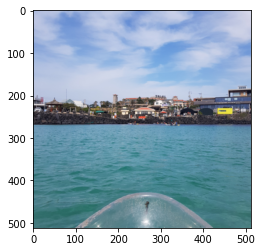

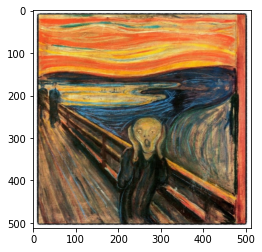

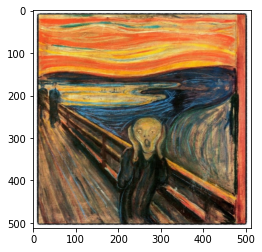

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])
torch.Size([1, 512, 16, 16]) torch.Size([1, 512, 16, 16]) torch.Size([1, 512, 16, 16])


RuntimeError: ignored

In [ ]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize([imsize, imsize]),
                             transforms.ToTensor()])

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

path = "drive/MyDrive/image/unnamed.jpg"
path2 = "drive/MyDrive/image/ocean1.jpg"

content = image_loader(path)
style = image_loader(path2)

model = StyleTransfer()
model.train(content, style)